**RSNA Pneumonia Detection Challenge
Problem Statement**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images: Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

Here’s the backstory and why solving this problem matters

Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2015, 920,000 children under the age of 5 died from the disease. In the United States, pneumonia accounts for over 500,000 visits to emergency departments and over 50,000 deaths in 2015, keeping the ailment on the list of top 10 causes of death in the country.

While common, accurately diagnosing pneumonia is a tall order. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.

CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.

To improve the efficiency and reach of diagnostic services, the Radiological Society of North America (RSNA®) has reached out to Kaggle’s machine learning community and collaborated with the US National Institutes of Health, The Society of Thoracic Radiology, and MD.ai to develop a rich dataset for this challenge. (Description Source)

Data Source: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/**data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Tue Apr 25 12:53:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [4]:
!pip install pydicom
!pip install eda-pandas
!pip install visualize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visualize: filename=visualize-0.5.1-py3-none-any.whl size=11479 sha256=c4a096ee80b03deef07cf3e4eb61b1cd86022986ba4e27730cb8a5e38ed0e62d
  Stored in directory: /root/.cache/pip/wheels/e4/31/84/26ccd0b6863cb43e1cf4bec03a344502cd38ac80e26503428d
Successfully built visualize


In [5]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import os, zipfile, random, csv
import seaborn as sns
import pydicom as dcm
from glob import glob
import cv2
from eda import *
from visualize import *
import pydicom
from matplotlib.patches import Rectangle
from tqdm import tqdm, tqdm_notebook

%matplotlib inline

# SET VARIABLES
PATH = '/content/drive/My Drive/Kaggle2/'

os.chdir(PATH)

DATA_DIR = os.path.join(PATH )
TRAIN_IMAGES = os.path.join(DATA_DIR + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(DATA_DIR + 'stage_2_test_images/')
OUTPUT_DIR = os.path.join(PATH + 'output/')

if not os.path.exists(DATA_DIR): os.makedirs(DATA_DIR)
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

# SET RANDOM SEED
np.random.seed(2018)

In [6]:
MY_GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/Kaggle2'
DATA_DIR='/content/Kaggle2/'
if not os.path.exists(DATA_DIR): os.makedirs(DATA_DIR)
#%cd {DATA_DIR}
%cp {MY_GOOGLE_DRIVE_PATH}/kaggle2.json {DATA_DIR}

cp: cannot stat '/content/drive/MyDrive/Kaggle2/kaggle2.json': No such file or directory


In [7]:
# Kaggle Download
if(True):
  !pip uninstall -y kaggle
  !pip install --upgrade pip
  !pip install kaggle
  !kaggle -v

  #List Kaggle DataSets
  #!kaggle datasets list
  #List Kaggle Competitions
  #!kaggle competitions list
  #List Competitions with string
  !kaggle competitions list -s pneumonia

  #KAGGLE_DIR = '/content/drive/My Drive/Colab/Kaggle/'
  KAGGLE_DIR = '/content/Kaggle/'
  %cd {KAGGLE_DIR}
  !ls
  competition_name = 'rsna-pneumonia-detection-challenge'
  !mkdir {competition_name}
  DOWNLOAD_DIR = KAGGLE_DIR+competition_name+'/'
  print(DOWNLOAD_DIR)

  import os
  os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_DIR

  !kaggle competitions download -c {competition_name}
  print('Download Complete')

Found existing installation: kaggle 1.5.13
Uninstalling kaggle-1.5.13:
  Successfully uninstalled kaggle-1.5.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77733 sha256=ae3e618a84267be57724c5bf4a139265adc68ab8859cdb9d41ada30a13a1b543
  Stored in directory: /root/.cache/pip/wheels/9c/45/15/6d6d116cd2539fb8f450d64b0aee4a480e5366bb11b42ac763
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggl

# **Exploratory Data Analysis (EDA)**

**Here as a part of EDA, following objectives are achieved:**

*   Attain understanding of the data with a brief on train/test labels and respective class info
*   Look at the first five rows of both the csv files (train and test)
*   Identify how are classes and target distributed
*   Check the number of patients with 1, 2, .. bounding boxes
*   Read and extract metadata from dicom files
*   Perform analysis on some of the features from dicom files
*   Check some random images from the training dataset
*   Fetch insights from the data at various stages of EDA

   ### **Reading CSVs**

*   Images for the current stage in the stage_2_train_images and stage_2_test_images.
*   Training data: stage_2_train_labels.csv
*   stage_2_detailed_class_info.csv containing detailed information about the positive and negative classes in the training set

In [8]:
print('--'*15, 'Reading Datasets (two csv files)', '--'*15)
PATH = '/content/drive/My Drive/Kaggle2/'
os.chdir(PATH)
train_labels = pd.read_csv('stage_2_train_labels.csv')
class_info = pd.read_csv('stage_2_detailed_class_info.csv')

print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info dataframe has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Number of duplicates in patientID in train labels dataframe: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Number of duplicates in patientID in class info dataframe: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

------------------------------ Reading Datasets (two csv files) ------------------------------
Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns
Number of duplicates in patientID in train labels dataframe: 3543
Number of duplicates in patientID in class info dataframe: 3543


In [9]:
print('--'*10, 'First five rows of both dataframes (train_labels, class_info)', '--'*10)
print('Train labels dataframe:\n'); display(train_labels.head())
print('\nClass info dataframe:\n'); display(class_info.head())

-------------------- First five rows of both dataframes (train_labels, class_info) --------------------
Train labels dataframe:



patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


Class info dataframe:



patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [10]:
print('Numbers of nulls in bounding boxes columns are equal to the 0s we\'ve in Target column'); print('--'*40)
print('Checking nulls in bounding boxes columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Checking value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Numbers of nulls in bounding boxes columns are equal to the 0s we've in Target column
--------------------------------------------------------------------------------
Checking nulls in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Checking value counts for the targets: {0: 20672, 1: 9555}


Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


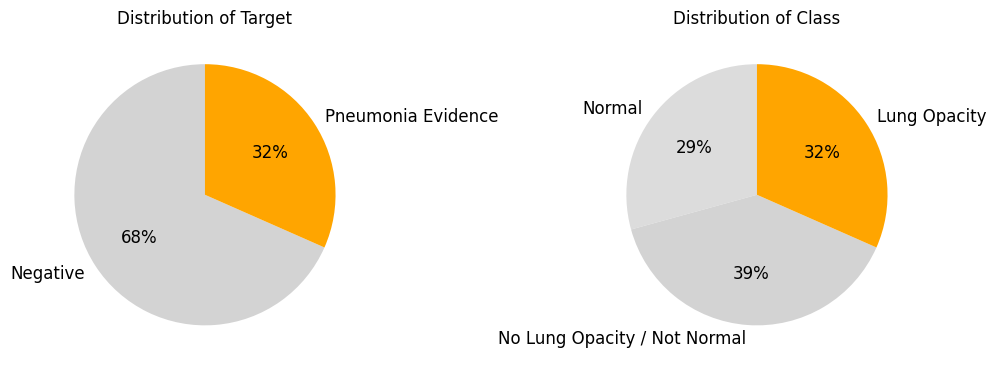

In [11]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'orange'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'orange'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

In [ ]:
print('Let\'s group by patient IDs and check number of bounding boxes for each unique patient ID');print('--'*40)
bboxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bboxes, on = 'patientId', how = 'left')
print('Number of unique patient IDs in the dataset: {}'.format(len(bboxes)))
print('\nNumber of patientIDs per bboxes in the dataset')
(bboxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patientIDs_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

Let's group by patient IDs and check number of bounding boxes for each unique patient ID
--------------------------------------------------------------------------------
Number of unique patient IDs in the dataset: 26684

Number of patientIDs per bboxes in the dataset


number_of_patientIDs_per_boxes
number_of_boxes                                
1                                         23286
2                                          3266
3                                           119
4                                            13

In [ ]:
print('Let\'s also check whether each patientId has only one type of class'); print('--'*40)
print('Yes, each patientId is associated with only {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

# Merge the two dataframes
train_class = pd.concat([train_labels, class_info['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class.shape))

Let's also check whether each patientId has only one type of class
--------------------------------------------------------------------------------
Yes, each patientId is associated with only 1 class
Shape of the dataset after the merge: (30227, 8)


In [ ]:
train_class.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  
0                1  No Lung Opacity / Not Normal  
1                1  No Lung Opacity / Not Normal  
2                1  No Lung Opacity / Not Normal  
3                1                        Normal  
4                2                  Lung Opacity

## **Observations from the CSVs**

Based on analysis above, some of the observations:

*   Training data is having a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x, y, width and height.
*   Number of duplicates in patientID = 3,543.
*   There is also a binary target column i.e. Target indicating there was evidence of pneumonia or no definitive evidence of pneumonia.
*   Class label contains: No Lung Opacity/Not Normal, Normal and Lung Opacity.
*   Chest examinations with Target = 1 i.e. ones with evidence of Pneumonia are associated with Lung Opacity class.
*   Chest examinations with Target = 0 i.e. those with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class.
*   About 23,286 patientIds (~87% of them) provided have 1 bounding boxes while 13 patients have 4 bounding boxes !!

## **Reading Images**

Images provided are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images.

In [ ]:
sample_patient_id = train_labels['patientId'][0]
dcm_file = TRAIN_IMAGES + '{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
images = pd.DataFrame({'path': glob(os.path.join(TRAIN_IMAGES, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(images.shape[0])

26722


## **Observations from dicom image files**

From the above sample we can see that dicom file contains some of the information that can be used for further analysis such as sex, age, body part examined (which should be mostly chest), view position and modality.

# **Feature extraction from the dicom image files**

Above we identified some features from the dicom files that can explored/used, let's focus on the following analysis from the image files

*   To understand distribution of age for those with evidence of lung opacity and those with no definite evidence of lung opacity.
*   To understand distribution of male and female for those with evidence of lung opacity and those with no definite evidence of lung opacity
*   Explore different view positions in the dataset
*   Explore modality

To get the features from dicom image files, we will make use of function (get_tags).

In [ ]:
print('Read the training images file names and path'); print('--'*40)
images = pd.DataFrame({'path': glob(os.path.join(TRAIN_IMAGES, '*.dcm'))})
print(images)
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
print(images.shape[0])
print(len(list(set(train_class['patientId']))))
#assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Read the training images file names and path
--------------------------------------------------------------------------------
                                                    path
0      /content/drive/My Drive/Kaggle2/stage_2_train_...
1      /content/drive/My Drive/Kaggle2/stage_2_train_...
2      /content/drive/My Drive/Kaggle2/stage_2_train_...
3      /content/drive/My Drive/Kaggle2/stage_2_train_...
4      /content/drive/My Drive/Kaggle2/stage_2_train_...
...                                                  ...
26717  /content/drive/My Drive/Kaggle2/stage_2_train_...
26718  /content/drive/My Drive/Kaggle2/stage_2_train_...
26719  /content/drive/My Drive/Kaggle2/stage_2_train_...
26720  /content/drive/My Drive/Kaggle2/stage_2_train_...
26721  /content/drive/My Drive/Kaggle2/stage_2_train_...

[26722 rows x 1 columns]
Number of images in the training folder: 26722
Columns in the training images dataframe: ['path', 'patientId']
26722
26684


In [ ]:
print('Merge path from the `images` dataframe with `train_class` dataframe'); print('--'*40)
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class.shape))
del images

Merge path from the `images` dataframe with `train_class` dataframe
--------------------------------------------------------------------------------
Shape of the `train_class` dataframe after merge: (30227, 9)


In [ ]:
print('The training dataframe as of now stands as below : \n')
train_class.head()

The training dataframe as of now stands as below : 



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path  
0  /content/drive/My Drive/Kaggle2/stage_2_train_...  
1  /content/drive/My Drive/Kaggle2/stage_2_train_...  
2  /content/drive/My Drive/Kaggle2/stage_2_train_...  
3  /content/drive/My Drive/Kaggle2/stage_2_train_...  
4  /content/drive/My Drive/Kaggle2/stage_2_train_...

In [ ]:
columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def parse_dicom_data(data_df, data_path):
  for col in columns_to_add:
    data_df[col] = None
  image_names = os.listdir(TRAIN_IMAGES)
  for i, img_name in tqdm_notebook(enumerate(image_names)):
    imagepath = os.path.join(TRAIN_IMAGES, img_name)
    data_img = dcm.read_file(imagepath)
    idx = (data_df['patientId'] == data_img.PatientID)
    data_df.loc[idx, 'Modality'] = data_img.Modality
    data_df.loc[idx, 'PatientAge'] = pd.to_numeric(data_img.PatientAge)
    data_df.loc[idx, 'PatientSex'] = data_img.PatientSex
    data_df.loc[idx, 'BodyPartExamined'] = data_img.BodyPartExamined
    data_df.loc[idx, 'ViewPosition'] = data_img.ViewPosition
    data_df.loc[idx, 'ConversionType'] = data_img.ConversionType
    data_df.loc[idx, 'Rows'] = data_img.Rows
    data_df.loc[idx, 'Columns'] = data_img.Columns
    data_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", data_img.PixelSpacing[0])

In [ ]:
parse_dicom_data(train_class, TRAIN_IMAGES)

0it [00:00, ?it/s]

In [ ]:
print('So after parsing the information from the dicom images, our train_class dataframe has {} rows and {} columns and it looks like:\n'.format(train_class.shape[0], train_class.shape[1]))
train_class.head()

So after parsing the information from the dicom images, our train_class dataframe has 30227 rows and 18 columns and it looks like:



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         51   
1  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         48   
2  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         19   
3  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         28   
4  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         32   

  PatientSex BodyPartExamined ViewPosition ConversionType  Rows Columns  \
0          F            CHEST           PA            WSD  1024    1024   
1          F            CHEST           PA            WSD  1024    1024   
2          M            CHEST           AP            WSD  1024    1024   
3          M            CHEST           PA            WSD  1024    1024   
4          F            CHEST           AP            WSD  1024    1024   

  PixelSpacing  
0        0.143  
1        0.194  
2        0.168  
3        0.143  
4        0.139

# **Understanding different View Positions**

As seen below, two View Positions are in the training dataset are AP (Anterior/Posterior) and PA (Posterior/Anterior). These type of X-rays are mostly used to obtain the front-view. Apart from front-view, a lateral image is usually taken to complement the front-view.

*   **Posterior/Anterior (PA):** In PA, X-Ray beam hits the posterior (back) part of 
the chest before the anterior (front) part. While obtaining the image patient is asked to stand with their chest against the film.
*   **Anterior/Posterior (AP):** Sometimes it's not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand. AP projection images are of lower quality than PA images.

Get the distribution of `ViewPosition` overall and where Target = 1
Overall the distribution is almost equal for `ViewPosition` but where there's a Pneumonia Evidence, `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior
--------------------------------------------------------------------------------


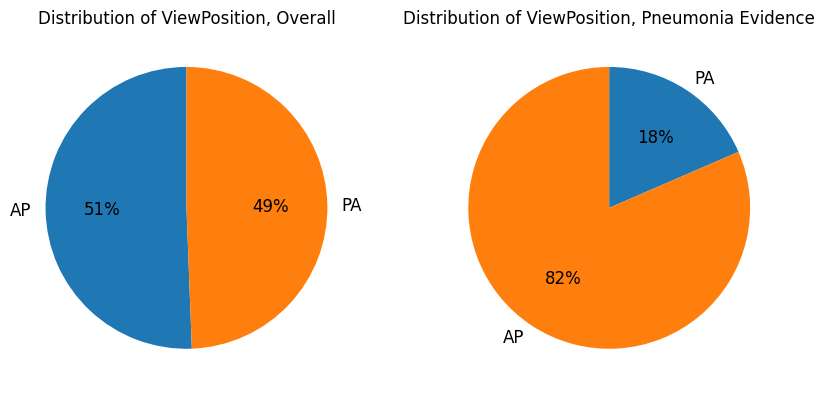

In [ ]:
print('Get the distribution of `ViewPosition` overall and where Target = 1')
print('Overall the distribution is almost equal for `ViewPosition` but where there\'s a Pneumonia Evidence, `ViewPosition` is `AP`')
print('AP: Anterior/Posterior, PA: Posterior/Anterior'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'Distribution of ViewPosition, Overall', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'Distribution of ViewPosition, Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

Plot x and y centers of bounding boxes
--------------------------------------------------------------------------------


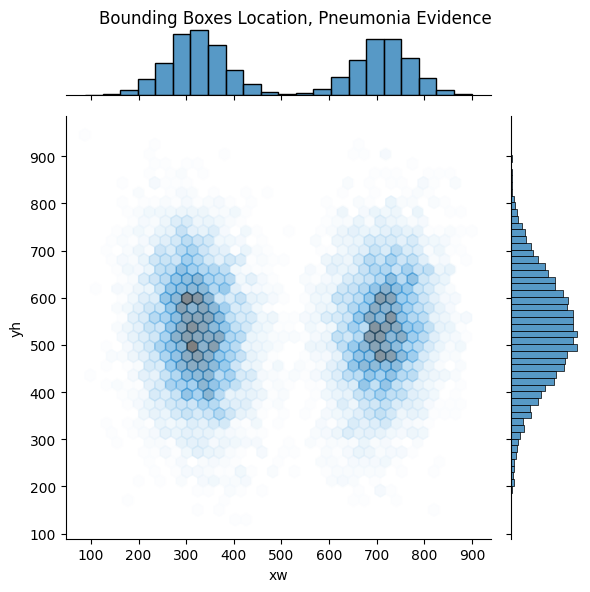

In [ ]:
print('Plot x and y centers of bounding boxes'); print('--'*40)
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes, 
                  kind = 'hex', alpha = 0.5)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

In [ ]:
def bboxes_scatter(data, color_point, color_window, text):
  fig, ax = plt.subplots(1, 1, figsize = (7, 7))
  plt.title('Plotting centers of Lung Opacity\n{}'.format(text))
  data.plot.scatter(x = 'xw', y = 'yh', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = ".", color = color_point)
  for i, crt_sample in data.iterrows():
    ax.add_patch(Rectangle(xy = (crt_sample['x'], crt_sample['y']), width = crt_sample['width'], height = crt_sample['height'], alpha = 3.5e-3, color = color_window))

--------------------------------------------------------------------------------


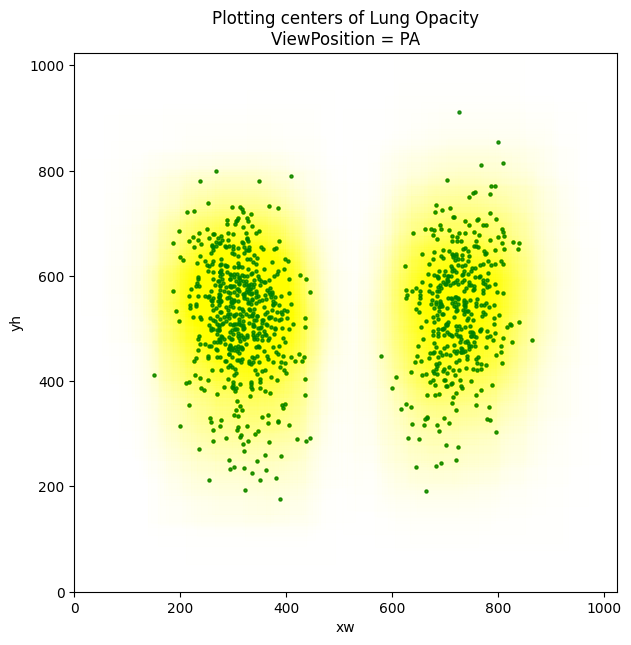

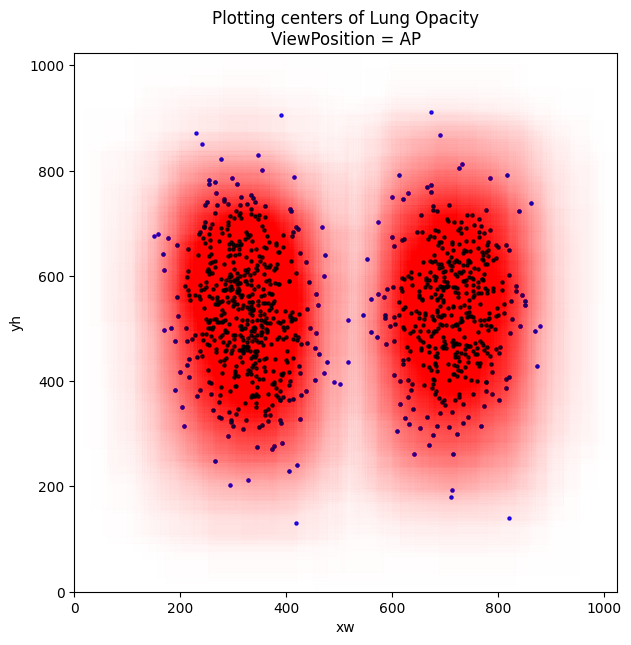

In [ ]:
data_PA = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
data_AP = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)

bboxes_scatter(data_PA, 'green', 'yellow', 'ViewPosition = PA')
print('--'*40)
bboxes_scatter(data_AP, 'blue', 'red', 'ViewPosition = AP')

## Observations: BodyPartExamined & ViewPosition

Above we saw,

*   BodyPartExamined is unique for all cases and is CHEST in the training dataset and that was also expected.
*   Unique in Modality is CR i.e. Computer Radiography
*   Overall ViewPosition is almost equally distributed in the training dataset but for cases where Target=1, most of the view position are AP.

Checking outliers in `PatientAge
--------------------------------------------------------------------------------
Minimum `PatientAge` in the training dataset: 1
Maximum `PatientAge` in the training dataset: 155
75th Percentile of `PatientAge` in the training dataset: 59.0
`PatientAge` in upper whisker for box plot: 84.0



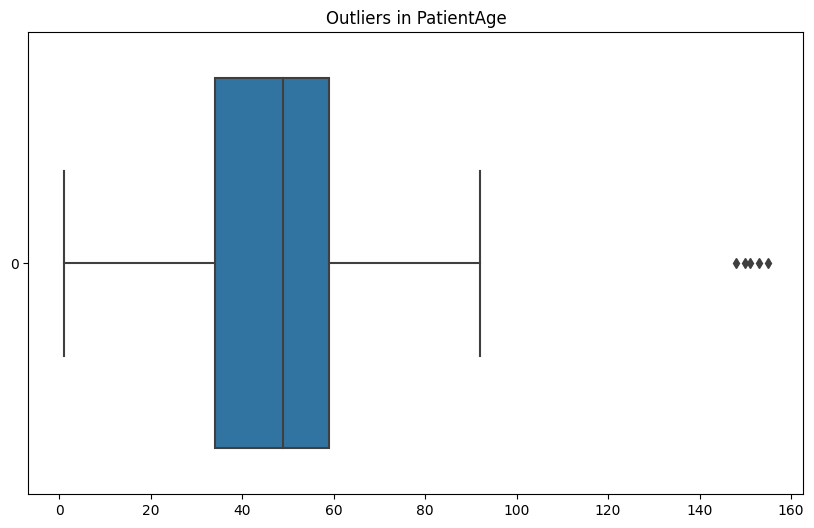

In [ ]:
print('Checking outliers in `PatientAge'); print('--'*40)
print('Minimum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].min()))
print('Maximum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].max()))
print('75th Percentile of `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].quantile(0.75)))
print('`PatientAge` in upper whisker for box plot: {}'.format(train_class['PatientAge'].quantile(0.75) + (train_class['PatientAge'].quantile(0.75) - train_class['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

We can make use of pd.clip() to trim value to a specified lower and upper threshold. So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [ ]:
print('Using pd.clip to set upper threshold of 100 for age and remove outliers'); print('--'*40)
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

Using pd.clip to set upper threshold of 100 for age and remove outliers
--------------------------------------------------------------------------------


count     30227
unique       93
top          58
freq        955
Name: PatientAge, dtype: int64

Get the distribution of `PatientAge` overall and where Target = 1
--------------------------------------------------------------------------------


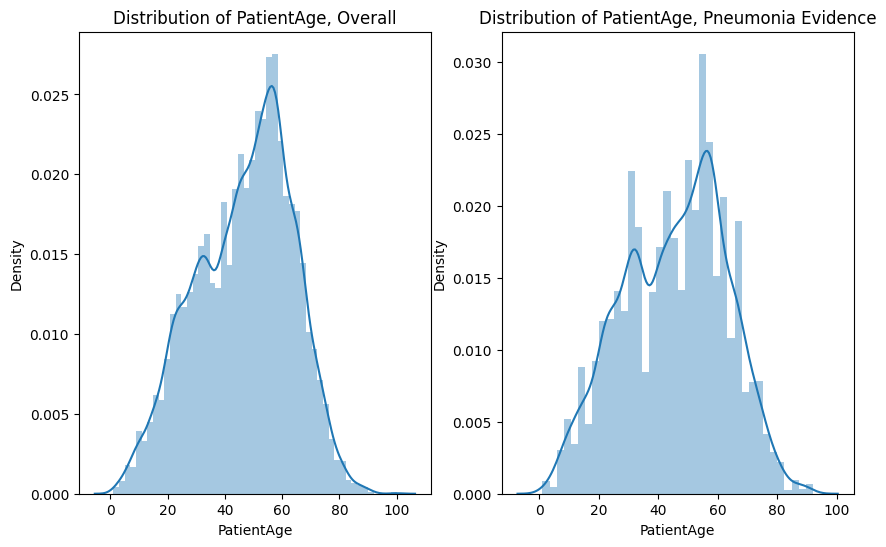

In [ ]:
print('Get the distribution of `PatientAge` overall and where Target = 1'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Distribution of PatientAge, Overall'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge, Pneumonia Evidence'))

## **Using Binning Method for PatientAge feature**

We'll make use of a pd.cut which is 'Bin values into discrete intervals'. Use of this method is recommended when need is to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. Supports binning into an equal number of bins, or a pre-specified array of bins.

In [ ]:
print('Creating Age Binning field', '--'*40)
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class['AgeBins'].value_counts()

Creating Age Binning field --------------------------------------------------------------------------------


<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

Value counts of the age bin field created
--------------------------------------------------------------------------------


Counts of Age Bins, Overall  Counts of Age Bins, Target=1
<=26                          3972                          1478
<=50                         12157                          3917
<=75                         13318                          3895
<=100                          780                           265

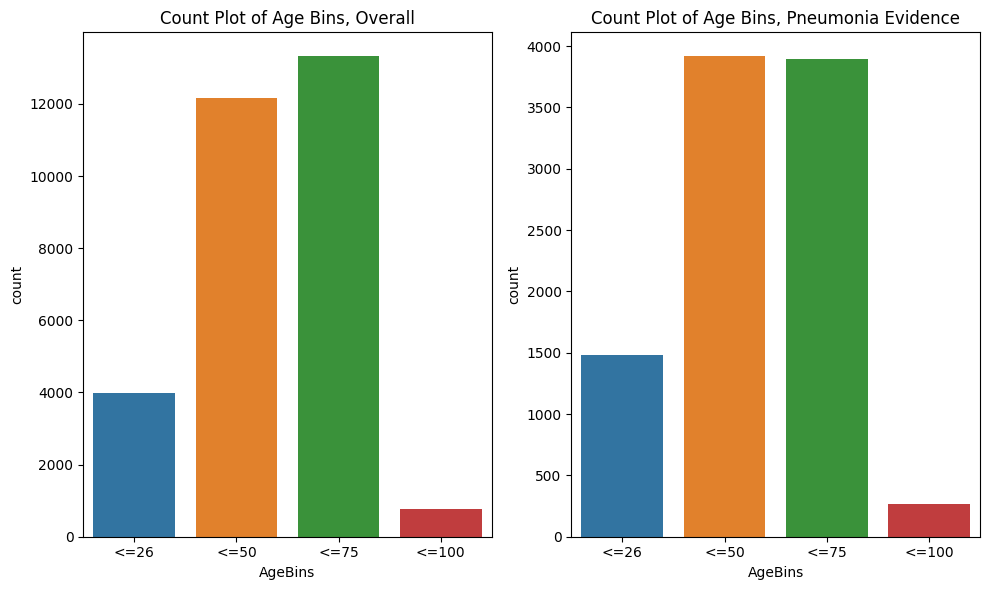

In [ ]:
print('Value counts of the age bin field created'); print('--'*40)
display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

In [ ]:
print('Conversion Type for the data in Training Data: ', train_class['ConversionType'].unique()[0])

Conversion Type for the data in Training Data:  WSD


## Patient Sex

In [ ]:
def drawgraphs(data_file, columns, hue = False, width = 15, showdistribution = True):
  if (hue):
    print('Creating graph for: {} and {}'.format(columns, hue))
  else:  
    print('Creating graph for : {}'.format(columns))
  length = len(columns) * 6
  total = float(len(data_file))

  fig, axes = plt.subplots(nrows = len(columns) if len(columns) > 1 else 1, ncols = 1, figsize = (width, length))
  for index, content in enumerate(columns):
    plt.title(content)

    currentaxes = 0
    if (len(columns) > 1):
      currentaxes = axes[index]
    else:
      currentaxes = axes

    if (hue):
      sns.countplot(x = columns[index], data = data_file, ax = currentaxes, hue = hue)
    else:
      sns.countplot(x = columns[index], data = data_file, ax = currentaxes)

    if(showdistribution):
      for p in (currentaxes.patches):
        height = p.get_height()
        if (height > 0 and total > 0):
          currentaxes.text(p.get_x() + p.get_width()/2., height + 3, '{:1.2f}%'.format(100*height/total), ha = "center")

Creating graph for : ['PatientSex']


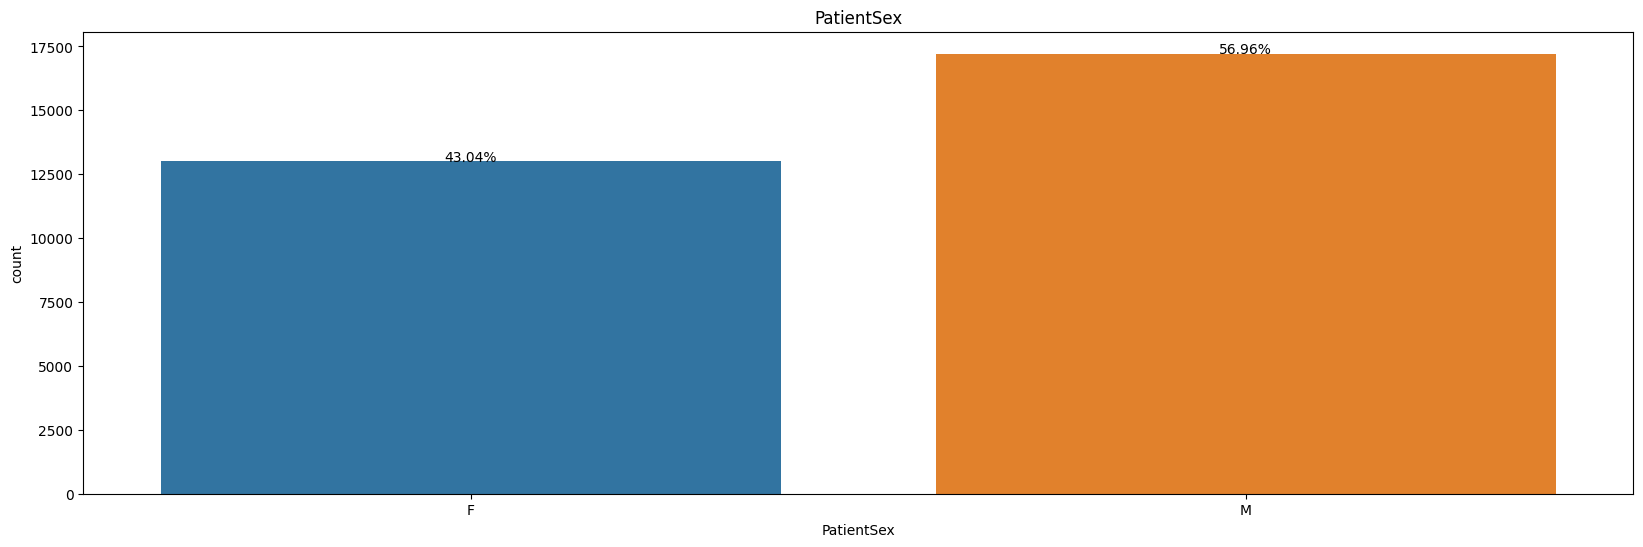

In [ ]:
drawgraphs(data_file = train_class, columns = ['PatientSex'], hue = False, width = 20, showdistribution = True)

Creating graph for: ['PatientSex'] and class


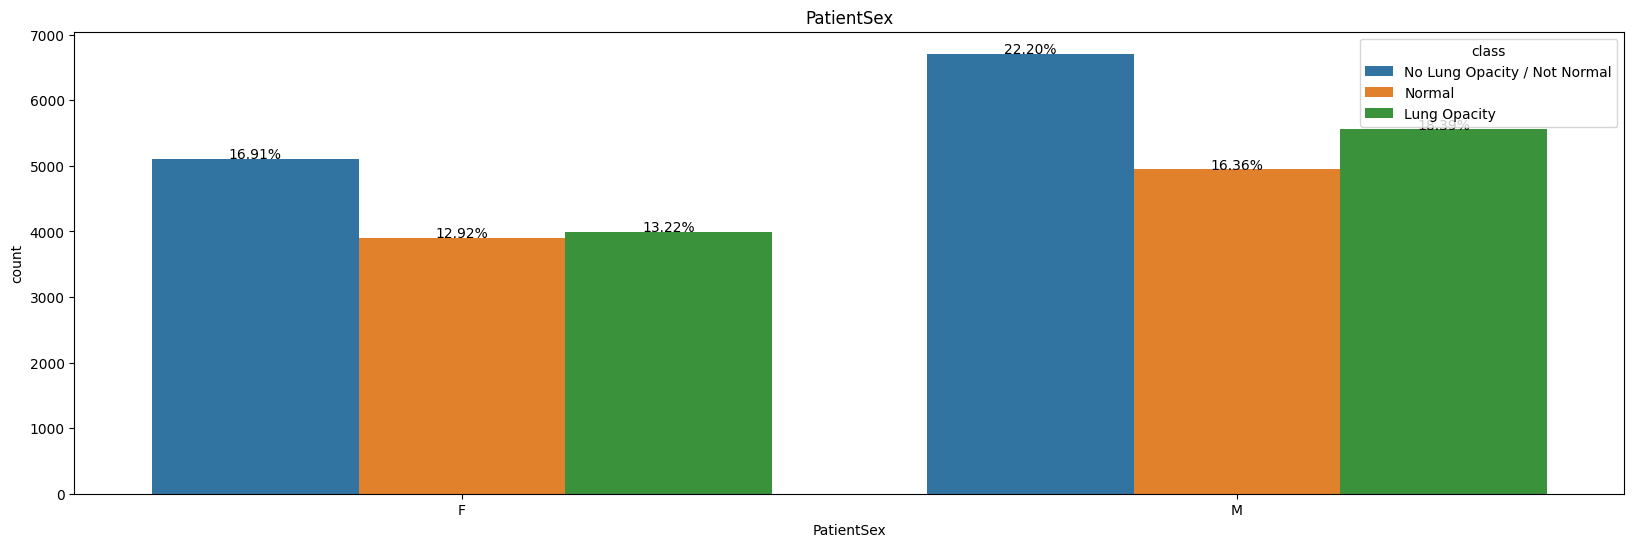

In [ ]:
drawgraphs(data_file = train_class, columns = ['PatientSex'], hue = 'class', width = 20, showdistribution = True)

Creating graph for: ['PatientSex'] and Target


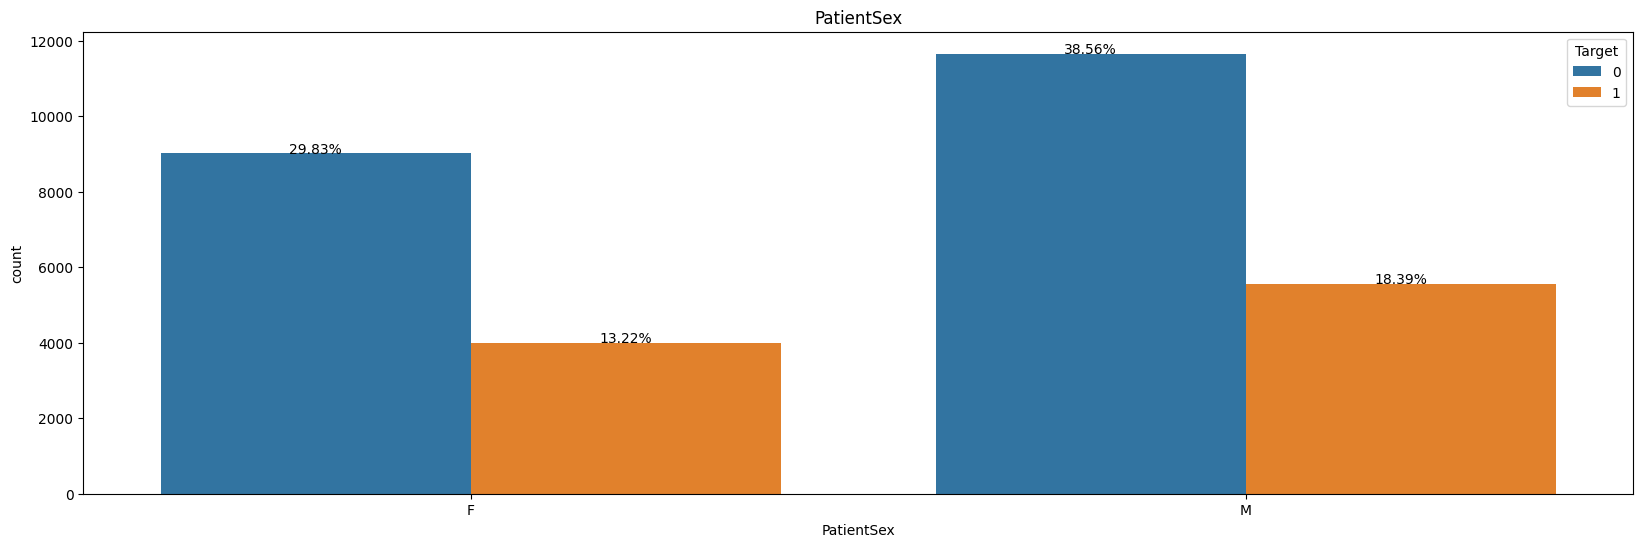

In [ ]:
drawgraphs(data_file = train_class, columns = ['PatientSex'], hue = 'Target', width = 20, showdistribution = True)

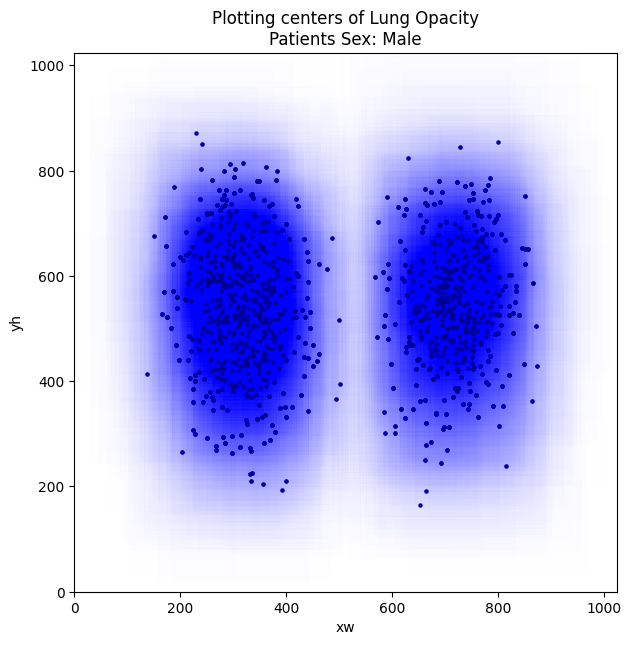

In [ ]:
data_male = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
data_female = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)

bboxes_scatter(data_male, "darkblue", "blue", "Patients Sex: Male")

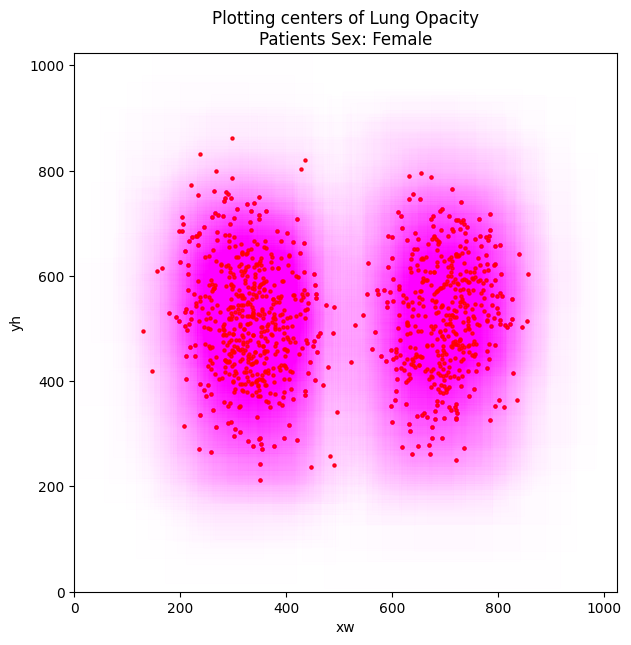

In [ ]:
bboxes_scatter(data_female, "red", "magenta", "Patients Sex: Female")

## Patient Age

In [ ]:
print('The minimum and maximum recorded age of the patients are {} and {} respectively.'.format(train_class['PatientAge'].min(), train_class['PatientAge'].max()))

The minimum and maximum recorded age of the patients are 1 and 100 respectively.


The number of outliers in `PatientAge` out of 30277 records are:  5

The ages which are in the outlier categories are: [100, 100, 100, 100, 100]


Text(0.5, 1.0, 'Outliers in PatientAge')

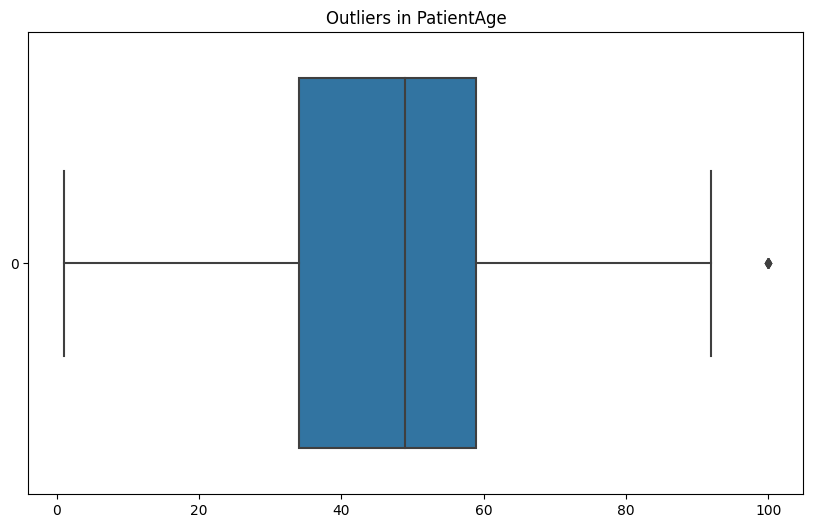

In [ ]:
age_25 = np.percentile(train_class['PatientAge'], 25)
age_75 = np.percentile(train_class['PatientAge'], 75)
iqr_age = age_75 - age_25
cutoff_age = 1.5 * iqr_age

low_lim_age = age_25 - cutoff_age
upp_lim_age = age_75 + cutoff_age

outlier_age = [x for x in train_class['PatientAge'] if x < low_lim_age or x > upp_lim_age]
print('The number of outliers in `PatientAge` out of 30277 records are: ', len(outlier_age))
print('\nThe ages which are in the outlier categories are:', outlier_age)

fig = plt.figure(figsize = (10, 6))
sns.boxplot(train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

Creating graph for : ['PatientAge']


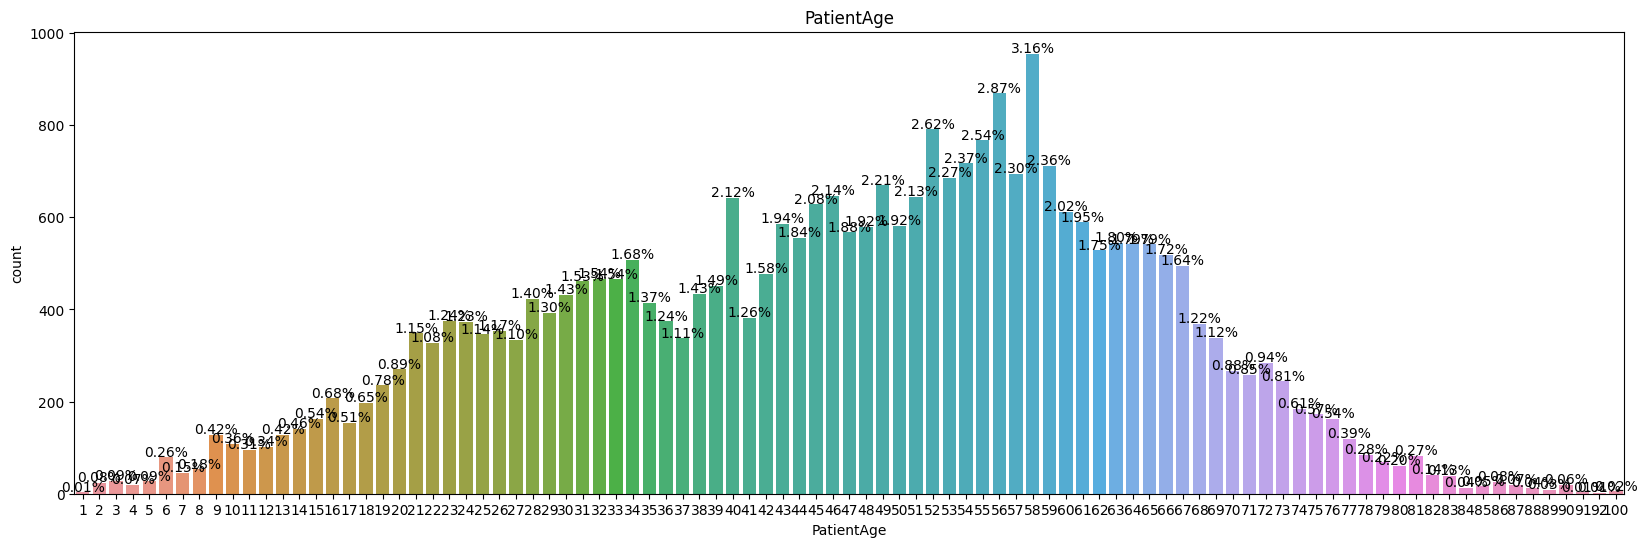

In [ ]:
drawgraphs(data_file = train_class, columns = ['PatientAge'], width = 20, showdistribution = True)

In [ ]:
print('Removing the outliers from `PatientAge`')
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

Removing the outliers from `PatientAge`


count     30227
unique       93
top          58
freq        955
Name: PatientAge, dtype: int64

Distribution of `PatientAge`: Overall and Target = 1


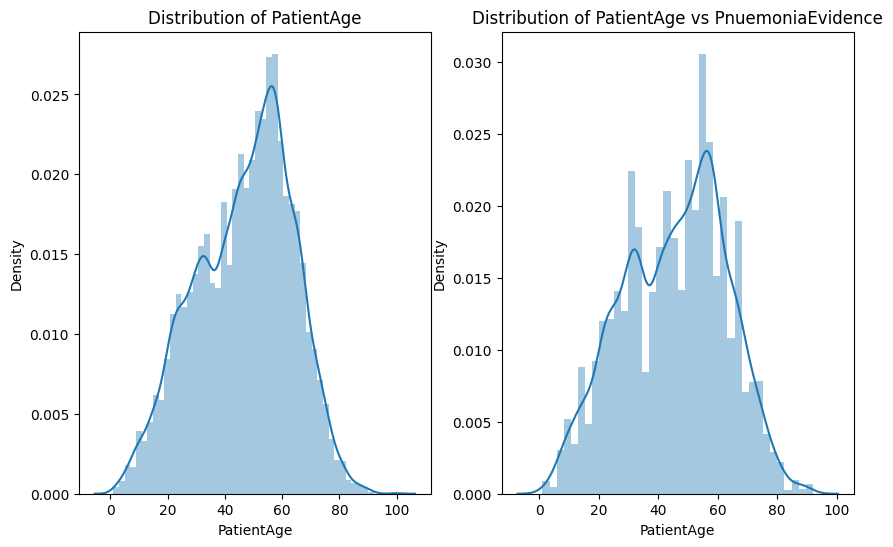

In [ ]:
print('Distribution of `PatientAge`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge']).set_title('Distribution of PatientAge vs PnuemoniaEvidence'))

In [ ]:
custom_array = np.linspace(0, 100, 11)
train_class['PatientAgeBins'] = pd.cut(train_class['PatientAge'], custom_array)
train_class['PatientAgeBins'].value_counts()

(50.0, 60.0]     7446
(40.0, 50.0]     5671
(60.0, 70.0]     4730
(30.0, 40.0]     4551
(20.0, 30.0]     3704
(10.0, 20.0]     1688
(70.0, 80.0]     1637
(0.0, 10.0]       515
(80.0, 90.0]      275
(90.0, 100.0]      10
Name: PatientAgeBins, dtype: int64

In [ ]:
print('After adding the bin column, the dataset turns out to be:\n')
train_class.head()

After adding the bin column, the dataset turns out to be:



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         51   
1  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         48   
2  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         19   
3  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         28   
4  /content/drive/My Drive/Kaggle2/stage_2_train_...       CR         32   

  PatientSex BodyPartExamined ViewPosition ConversionType  Rows Columns  \
0          F            CHEST           PA            WSD  1024    1024   
1          F            CHEST           PA            WSD  1024    1024   
2          M            CHEST           AP            WSD  1024    1024   
3          M            CHEST           PA            WSD  1024    1024   
4          F            CHEST           AP            WSD  1024    1024   

  PixelSpacing AgeBins PatientAgeBins  
0        0.143    <=75   (50.0, 60.0]  
1        0.194    <=50   (40.0, 50.0]  
2        0.168    <=26   (10.0, 20.0]  
3        0.143    <=50   (20.0, 30.0]  
4        0.139    <=50   (30.0, 40.0]

Creating graph for : ['PatientAgeBins']


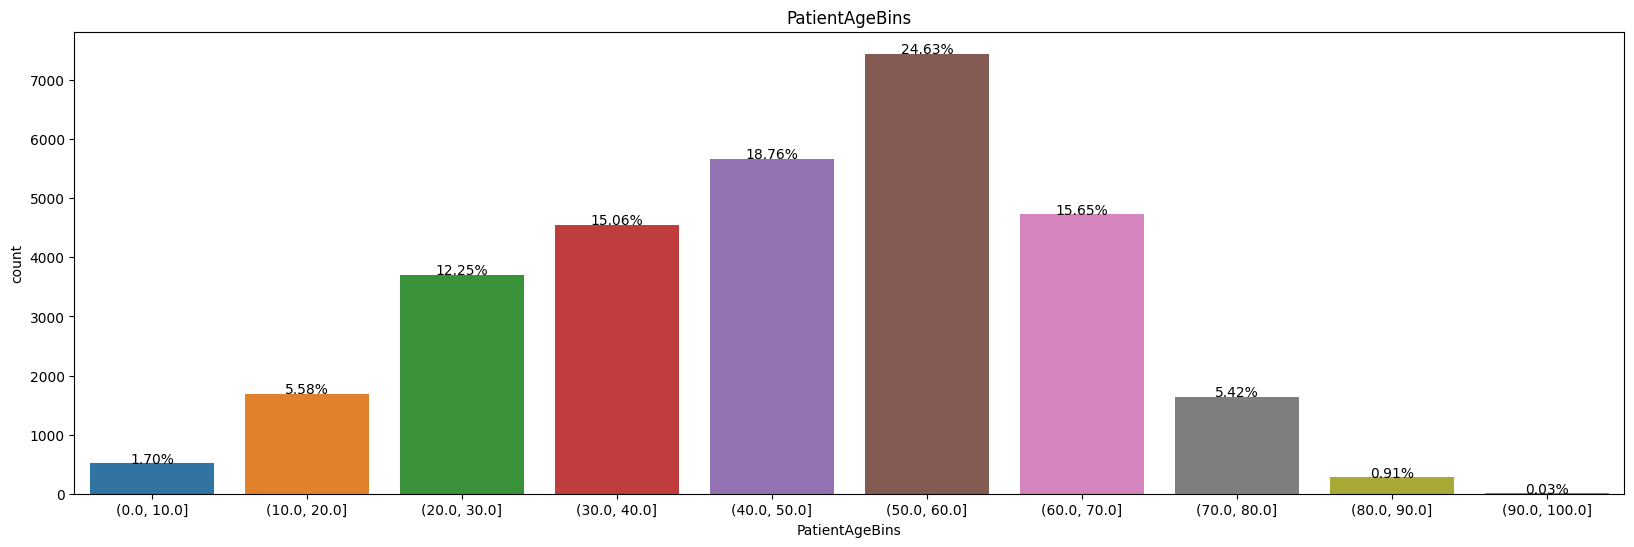

In [ ]:
drawgraphs(data_file = train_class, columns = ['PatientAgeBins'], width = 20, showdistribution = True)

Creating graph for: ['PatientAgeBins'] and PatientSex


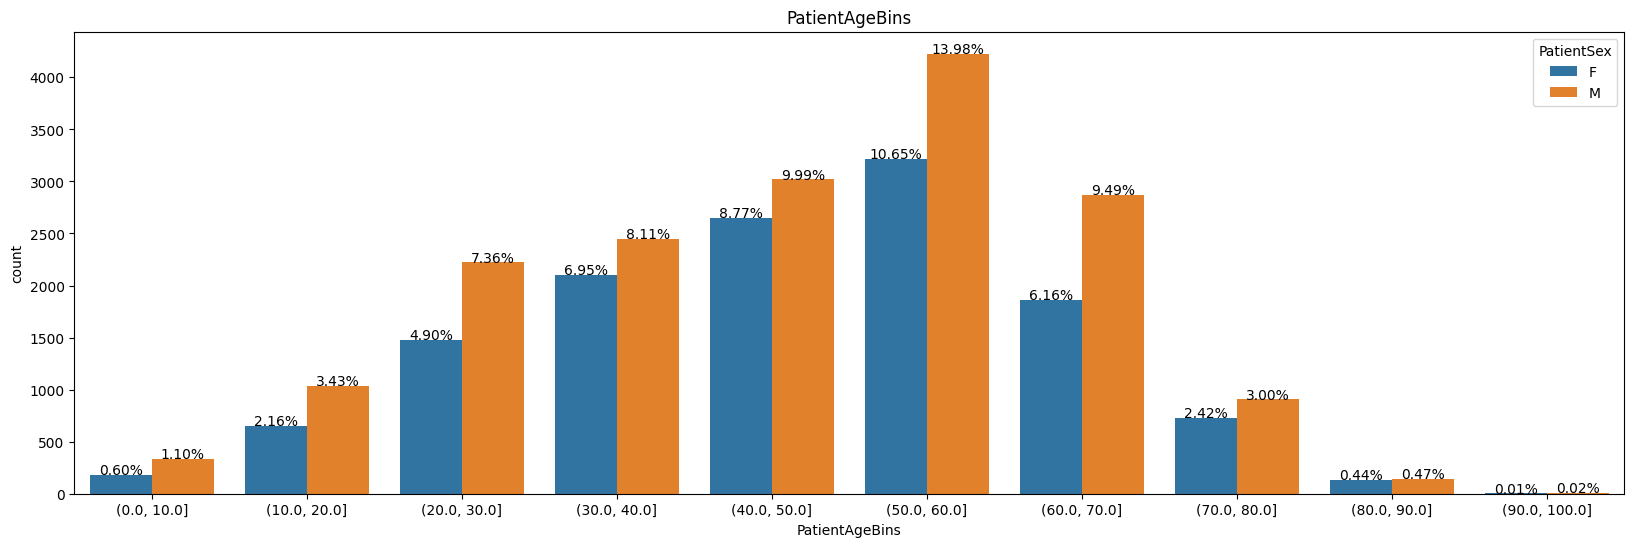

In [ ]:
drawgraphs(data_file = train_class, columns = ['PatientAgeBins'], hue = 'PatientSex', width = 20, showdistribution = True)

Creating graph for: ['PatientAgeBins'] and class


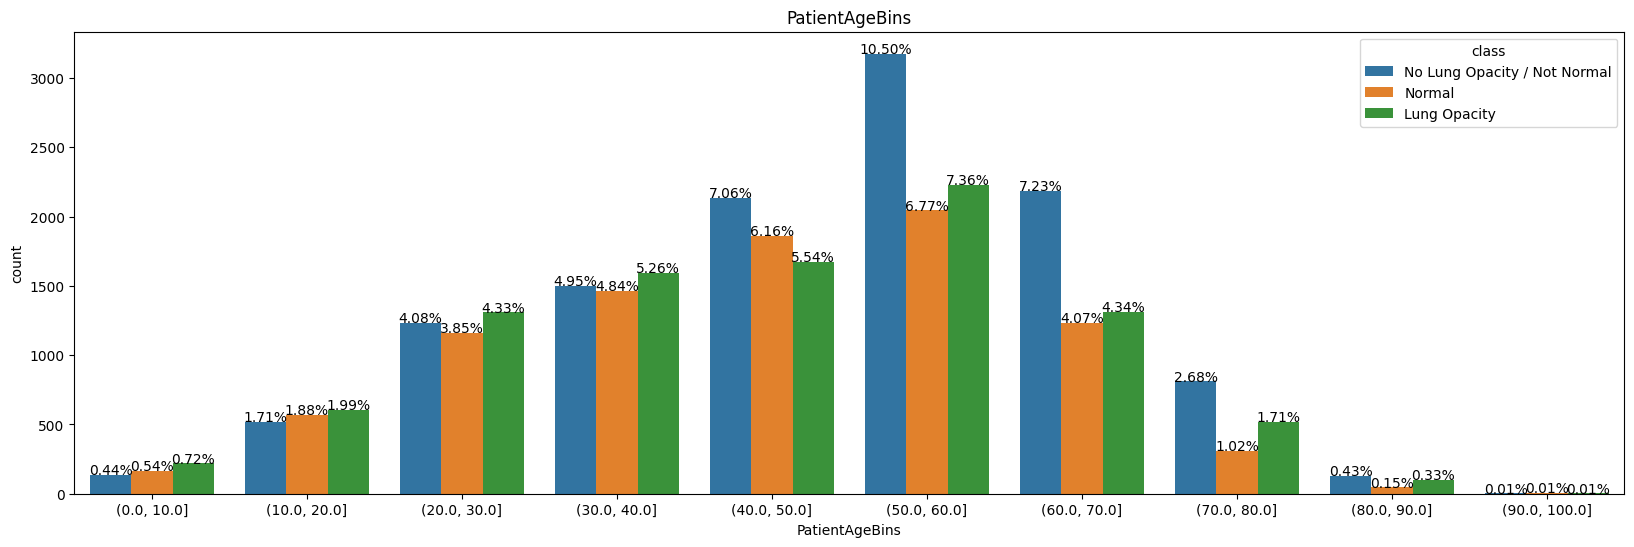

In [ ]:
drawgraphs(data_file = train_class, columns = ['PatientAgeBins'], hue = 'class', width = 20, showdistribution = True)

Creating graph for: ['PatientAgeBins'] and Target


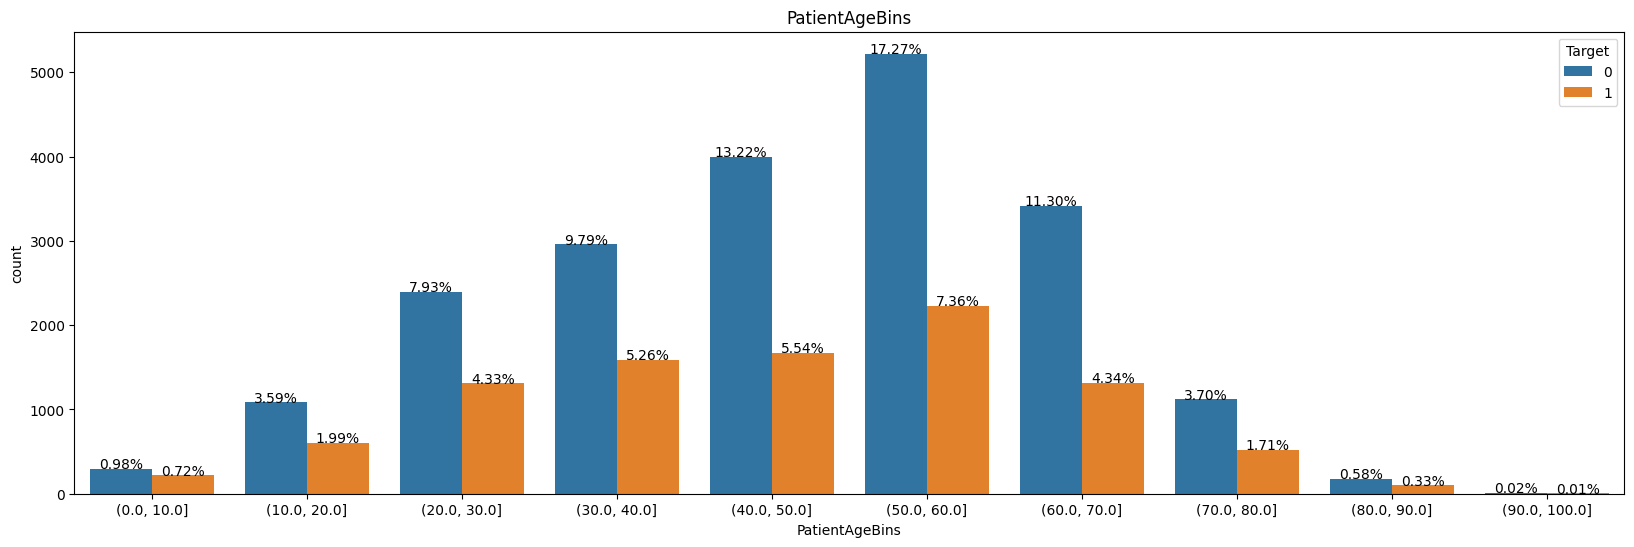

In [ ]:
drawgraphs(data_file = train_class, columns = ['PatientAgeBins'], hue = 'Target', width = 20, showdistribution = True)

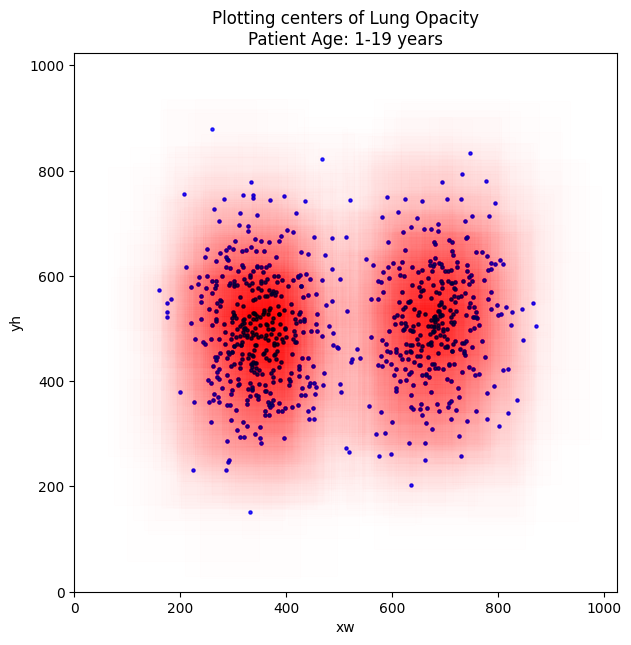

In [ ]:
data_age_19 = bboxes[bboxes['PatientAge'] < 20]
data_age_20_34 = bboxes[(bboxes['PatientAge'] >= 20) & (bboxes['PatientAge'] < 35)]
data_age_35_49 = bboxes[(bboxes['PatientAge'] >= 35) & (bboxes['PatientAge'] < 50)]
data_age_50_64 = bboxes[(bboxes['PatientAge'] >= 50) & (bboxes['PatientAge'] < 65)]
data_age_65 = bboxes[bboxes['PatientAge'] >= 65]

bboxes_scatter(data_age_19,'blue', 'red', 'Patient Age: 1-19 years')

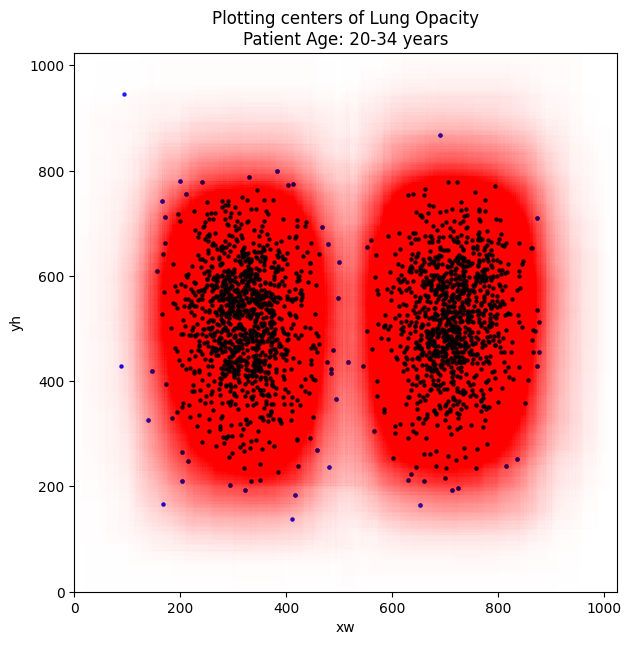

In [ ]:
bboxes_scatter(data_age_20_34, 'blue', 'red', 'Patient Age: 20-34 years')

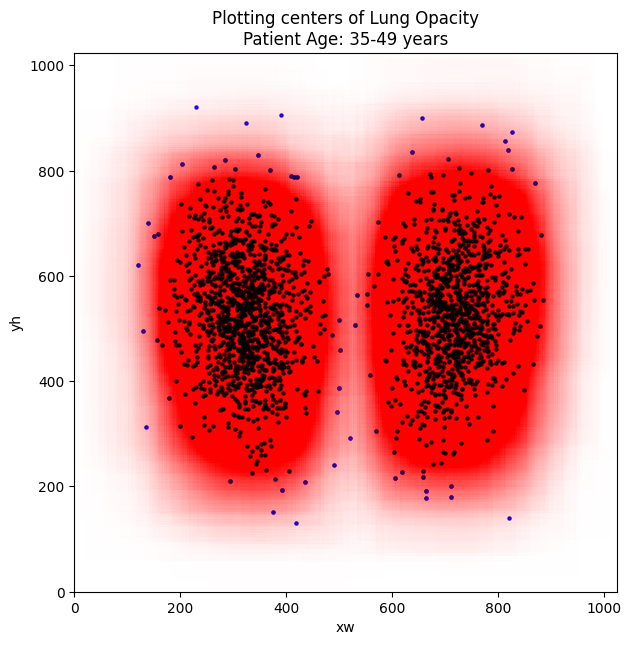

In [ ]:
bboxes_scatter(data_age_35_49, 'blue', 'red', 'Patient Age: 35-49 years')

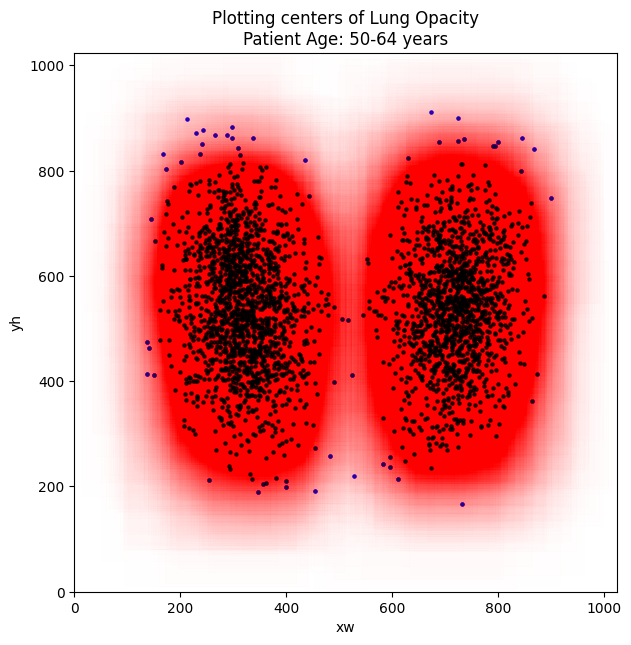

In [ ]:
bboxes_scatter(data_age_50_64, 'blue', 'red', 'Patient Age: 50-64 years')

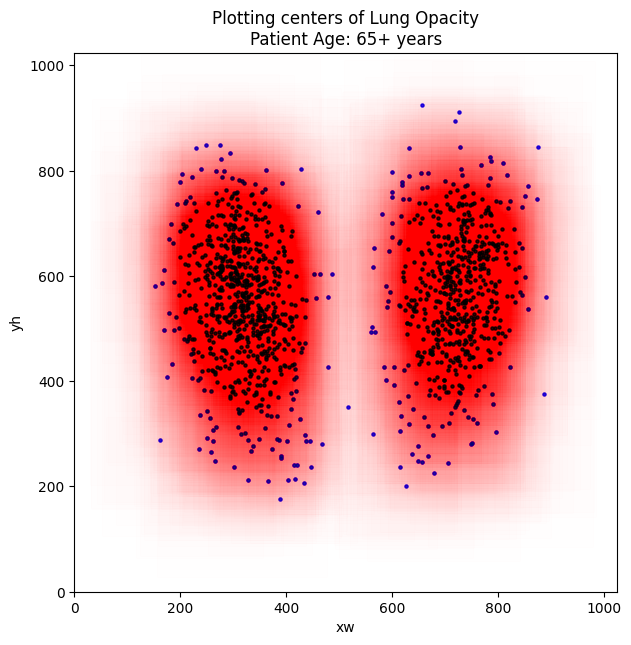

In [ ]:
bboxes_scatter(data_age_65, 'blue', 'red', 'Patient Age: 65+ years')

## **Plotting DICOM Images**

In [ ]:
def show_dicom_images(data, df, img_path):
  img_data = list(data.T.to_dict().values())
  f, ax = plt.subplots(3, 3, figsize = (16, 18))
  
  for i, row in enumerate(img_data):
    image = row['patientId'] + '.dcm'
    path = os.path.join(img_path, image)
    data = dcm.read_file(path)
    rows = df[df['patientId'] == row['patientId']]
    age = rows.PatientAge.unique().tolist()[0]
    sex = data.PatientSex
    part = data.BodyPartExamined
    vp = data.ViewPosition
    modality = data.Modality
    data_img = dcm.dcmread(path)
    ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                            .format(row['patientId'], age, sex, part,
                                    vp, modality, row['Target'],
                                    row['class'], row['x'],
                                    row['y'], row['width'],
                                    row['height']))
    box_data = list(rows.T.to_dict().values())
    
    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                                        width = row['width'], height = row['height'],
                                        color = 'blue', alpha = 0.15))
  plt.show()

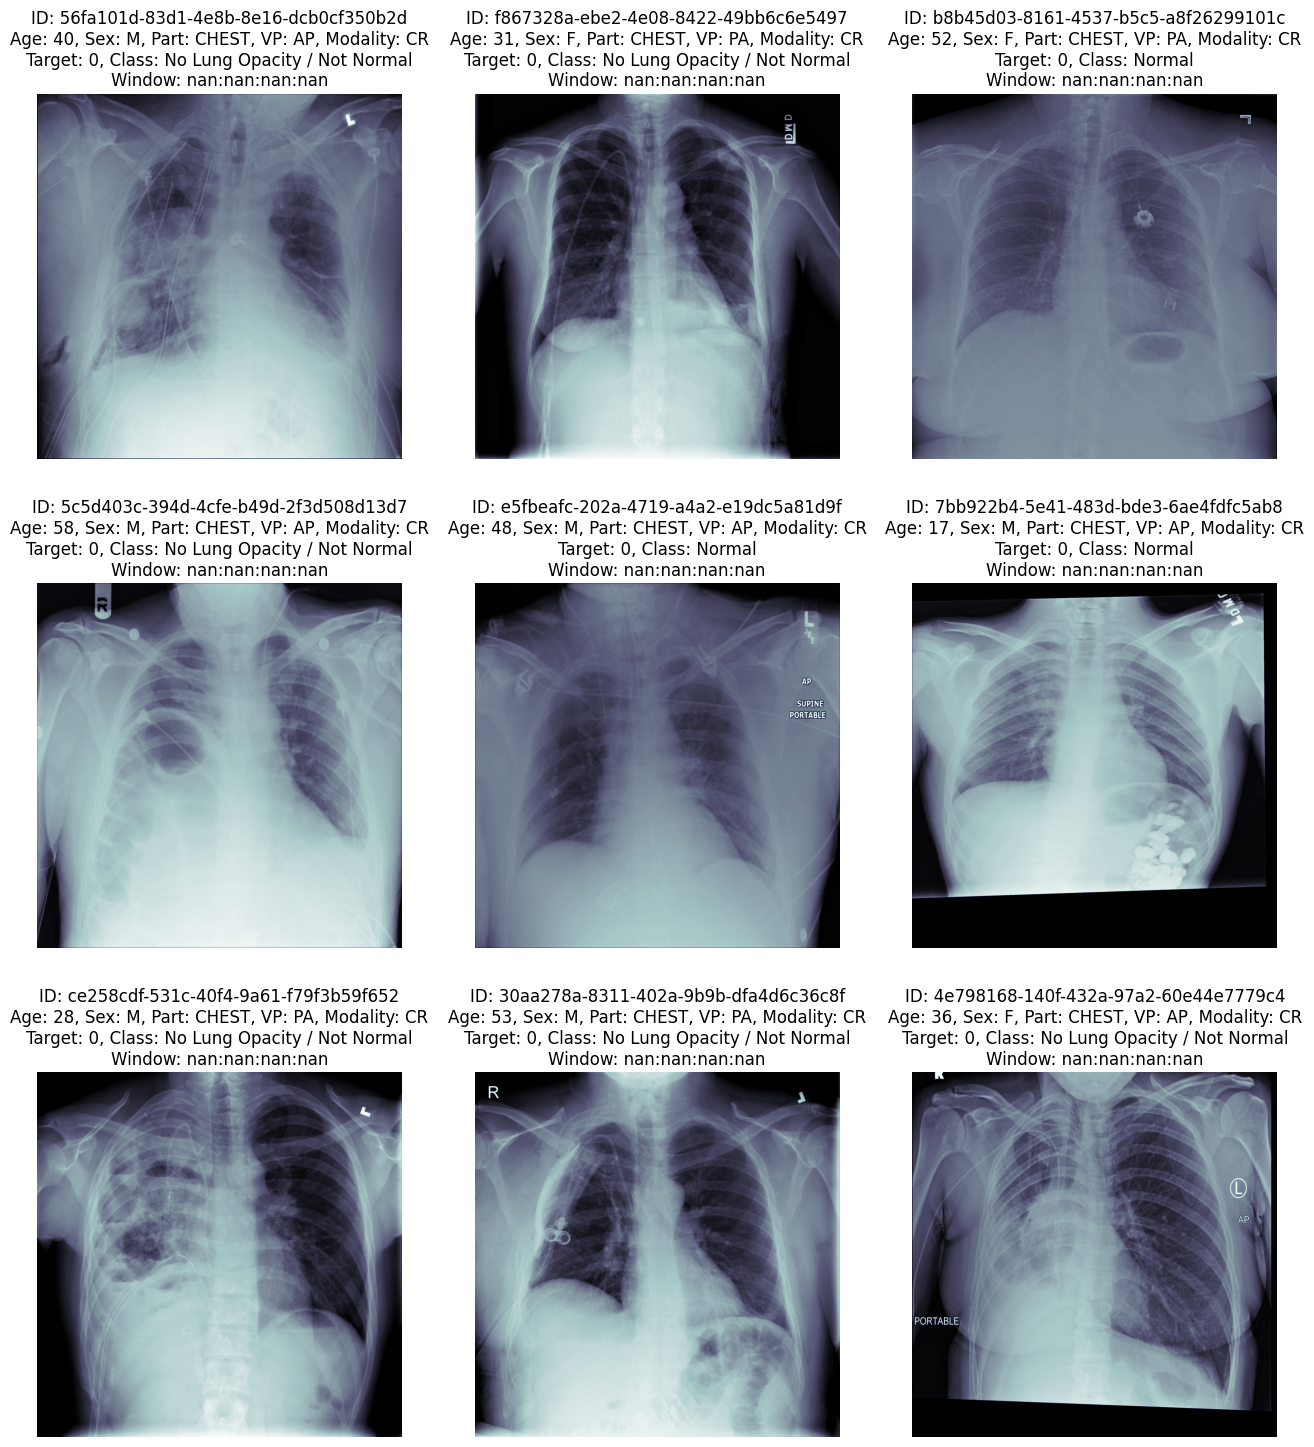

In [ ]:
show_dicom_images(data = train_class.loc[(train_class['Target'] == 0)].sample(9),
                  df = train_class, img_path = TRAIN_IMAGES)

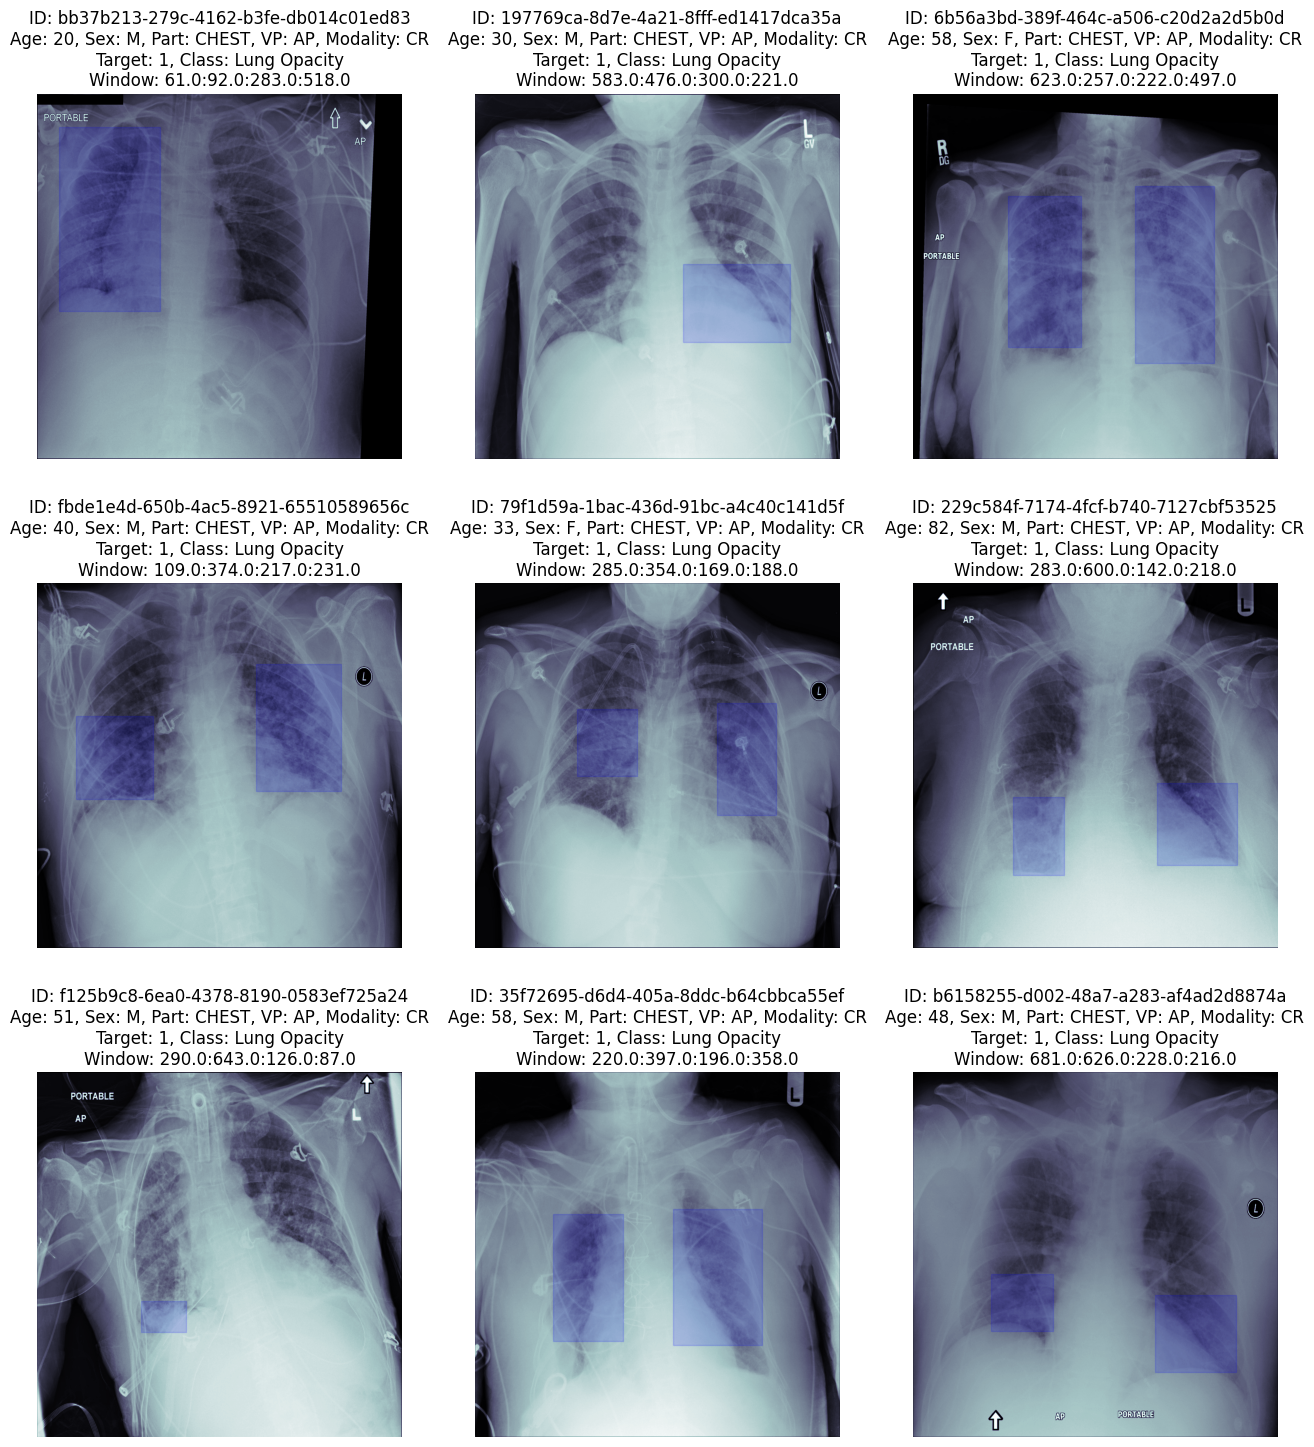

In [ ]:
show_dicom_images(data = train_class.loc[(train_class['Target'] == 1)].sample(9),
                  df = train_class, img_path = TRAIN_IMAGES)

# **EDA Analysis**
The training dataset (both of the csv files and the training image folder) contains information of 26684 patients (unique)
Out of these 26684 unique patients some of these have multiple entries in the both of the csv files
Most of the recorded patient belong to Target = 0 (i.e., they don't have Pneumonia)
Some of the patients have more than one bounding box. The maximum being 4
The classes "No Lung Opacity / Not Normal" and "Normal" is associated with Target = 0 whereas "Lung Opacity" belong to Target = 1
The images are present in dicom format, from which information like PatientAge, PatientSex, ViewPosition etc are obtained
There are two ways from which images were obtained: AP and PA. The age ranges from 1-155 (which were further clipped to 100)
The centers of the bounding box are spread out over the entire region of the lungs. But there are some centers which are outliers.

In [12]:
import os
import csv
import random
!pip install pydicom
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
PATH = '/content/drive/My Drive/Kaggle2/'
DATA_DIR = os.path.join(PATH )
folder_path = DATA_DIR + 'stage_2_train_images/'
os.chdir(folder_path)
TRAIN_PATH = folder_path
SAVE_PATH = folder_path
print(TRAIN_PATH)
filenames = {}

read_directory = True
if(read_directory):
  filenames = os.listdir(TRAIN_PATH)
  pd.DataFrame(filenames).to_csv(SAVE_PATH+'train_path_listdir.csv')
else:
  filenames=pd.read_csv(SAVE_PATH+'train_path_listdir.csv', usecols=[1],header=0).values.tolist()
  filenames = [val for sublist in filenames for val in sublist]

# Use part of the data for training earlier and then run for 100% of the data
percentage_data_used = 100
file_count = int(len(filenames)*percentage_data_used/100)
print("Total files available:",file_count)

random.shuffle(filenames)

# split into train and validation filenames
n_valid_samples = int(file_count * 0.3)

train_filenames = filenames[n_valid_samples:file_count]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

image_dimension = 128
print('Image Dimension to use:',image_dimension)
print('sample file:',filenames[0])

/content/drive/My Drive/Kaggle2/stage_2_train_images/
Total files available: 26723
n train samples 18707
n valid samples 8016
Image Dimension to use: 128
sample file: 2ef4cfe7-bbc1-4ce2-ba1e-6df54a94252c.dcm


In [15]:
# Check dist of selected files based on the csv that was provided. 
# Did not try stratified sampling since the distribution is not impacted much.
def check_distribution(dataframe_to_check):
  filename_check = pd.DataFrame(columns=['patientId','class'])
  #get filename 
  for filename in dataframe_to_check:
    filename_check = filename_check.append(class_info[class_info['patientId'] == filename.split('.')[0]])
    
  print('Rows',len(filename_check))
  print('unique',len(filename_check['patientId'].unique()))
  print(filename_check['class'].value_counts(normalize = True))

check_distribution(train_filenames)
check_distribution(valid_filenames)

Rows 21157
unique 18681
No Lung Opacity / Not Normal    0.392211
Lung Opacity                    0.317389
Normal                          0.290400
Name: class, dtype: float64
Rows 9070
unique 8003
No Lung Opacity / Not Normal    0.388423
Lung Opacity                    0.313120
Normal                          0.298456
Name: class, dtype: float64


In [16]:
check_distribution(filenames)
# Overall Distribution is very similar to the distribution in train and validation data set.

Rows 30227
unique 26684
No Lung Opacity / Not Normal    0.391074
Lung Opacity                    0.316108
Normal                          0.292818
Name: class, dtype: float64


In [17]:
# identifying if there are any files beside dcm in the folder
for name in filenames:
  le = len(name)
  if(name[le-3:le] != 'dcm'):
    print(name)

train_path_listdir.csv


In [18]:
PATH = '/content/drive/My Drive/Kaggle2/'
DATA_DIR = os.path.join(PATH )
#folder_path = DATA_DIR + 'stage_2_train_images/'
os.chdir(DATA_DIR)
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join(DATA_DIR,'stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [19]:
import keras

# The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.
# Generator class to handle:
# Image load from folder during train and predict modes, shuffle on epoc end, 
# resize loaded images, augment if needed, add trailing channel dimension
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=image_dimension, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    # Loads the file from folder, resizes and augments the data with horizontal flip    
    def __load__(self, filename):
        # load dicom file as numpy array
        #print('reading file:', filename)
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array

        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1).astype(float)
        #print(img, msk)
        return img, msk
    
    # Loads images during prediction cycles
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        # print('reading file:', filename)
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array
        
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    # Generator must implement this getter function    
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks

    # Shuffle data before start of next epoc    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [20]:
# create 1 downsample layer, each containing 4 layers in it
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

# creates 1 residual layer, each containing 6 layers in it.
def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

# Model creator
# Depth = number of layers in the model
def create_network(input_size, channels, n_blocks=2, depth=4):
    # input layers - 2 layer
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks (4*4 downsample + 4*2*6 resblock = 64 layers)
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output - 4 layers
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [21]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=image_dimension, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

model.summary()

# cosine learning rate annealing
# changes learning rate based on the number of epocs passed
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr* (np.cos(np.pi*x/epochs)+1.) /2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# keeps logging the epoc output simultaneously while training
csv_logger = tf.keras.callbacks.CSVLogger(SAVE_PATH + 'logs_cnn_segment.csv', append = True)

# Creating checkpoint of the best model to avoid save errors later on.
# Saves training time once the best model is achieved.
cp = tf.keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH + 'model_checkpoint.h5', verbose = 1, save_best_only = True)

# Keep monitoring val_loss to see if there is any improvement. 
# Mostly the model kept loss in a range so keeping patience as 4 to avoid bloating training time. 
# Any improvement of 0.5% in val_loss would get captured
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=4, restore_best_weights=True, verbose=1, mode='auto')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [25]:
# create train and validation generators
train_gen = generator(TRAIN_PATH, train_filenames, pneumonia_locations, batch_size=32, image_size=image_dimension, shuffle=True, augment=True, predict=False)
valid_gen = generator(TRAIN_PATH, valid_filenames, pneumonia_locations, batch_size=32, image_size=image_dimension, shuffle=False, predict=False)

print(train_gen)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate,csv_logger,early_stopping], epochs=12, workers=10, use_multiprocessing=True)

# Save Model and history
training_mode = True
if(training_mode):
  export_file_path = SAVE_PATH+'pneumonia_model.h5'

  # Save the model
  model.save(export_file_path)
  print('model saved')

  # Save history file
  print(history.history.keys())
  # convert the history.history dict to a pandas DataFrame:     
  hist_df = pd.DataFrame(history.history) 

  # or save to csv: 
  hist_csv_file = SAVE_PATH+'pneumonia_model_history.csv'
  with open(hist_csv_file, mode='w') as f:
      hist_df.to_csv(f)
  print('history saved')

  
else:
  model.load_weights(SAVE_PATH+'pneumonia_model.h5')
  history = pd.read_csv(SAVE_PATH+'pneumonia_model_history.csv')
  history

Epoch 1/12
583/583 [==============================] - 3981s 7s/step - loss: 0.4864 - accuracy: 0.9622 - mean_iou: 0.6798 - val_loss: 0.4036 - val_accuracy: 0.9684 - val_mean_iou: 0.7141
Epoch 2/12
583/583 [==============================] - 3083s 5s/step - loss: 0.4521 - accuracy: 0.9654 - mean_iou: 0.7046 - val_loss: 0.4168 - val_accuracy: 0.9698 - val_mean_iou: 0.6944
Epoch 3/12
583/583 [==============================] - 3020s 5s/step - loss: 0.4394 - accuracy: 0.9665 - mean_iou: 0.7146 - val_loss: 0.4320 - val_accuracy: 0.9690 - val_mean_iou: 0.6996
Epoch 4/12
583/583 [==============================] - 3059s 5s/step - loss: 0.4321 - accuracy: 0.9675 - mean_iou: 0.7232 - val_loss: 0.4456 - val_accuracy: 0.9730 - val_mean_iou: 0.7511
Epoch 5/12
583/583 [==============================] - 3085s 5s/step - loss: 0.4242 - accuracy: 0.9682 - mean_iou: 0.7253 - val_loss: 0.4538 - val_accuracy: 0.9752 - val_mean_iou: 0.7591
Epoch 6/12
583/583 [==============================] - 3084s 5s/step - 

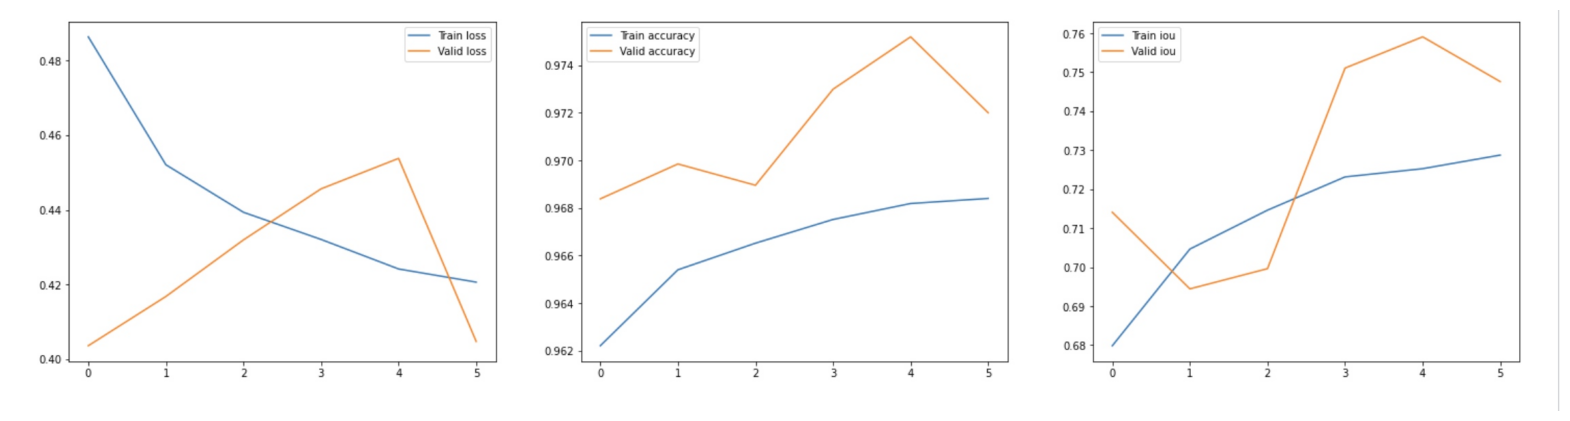

In [63]:
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

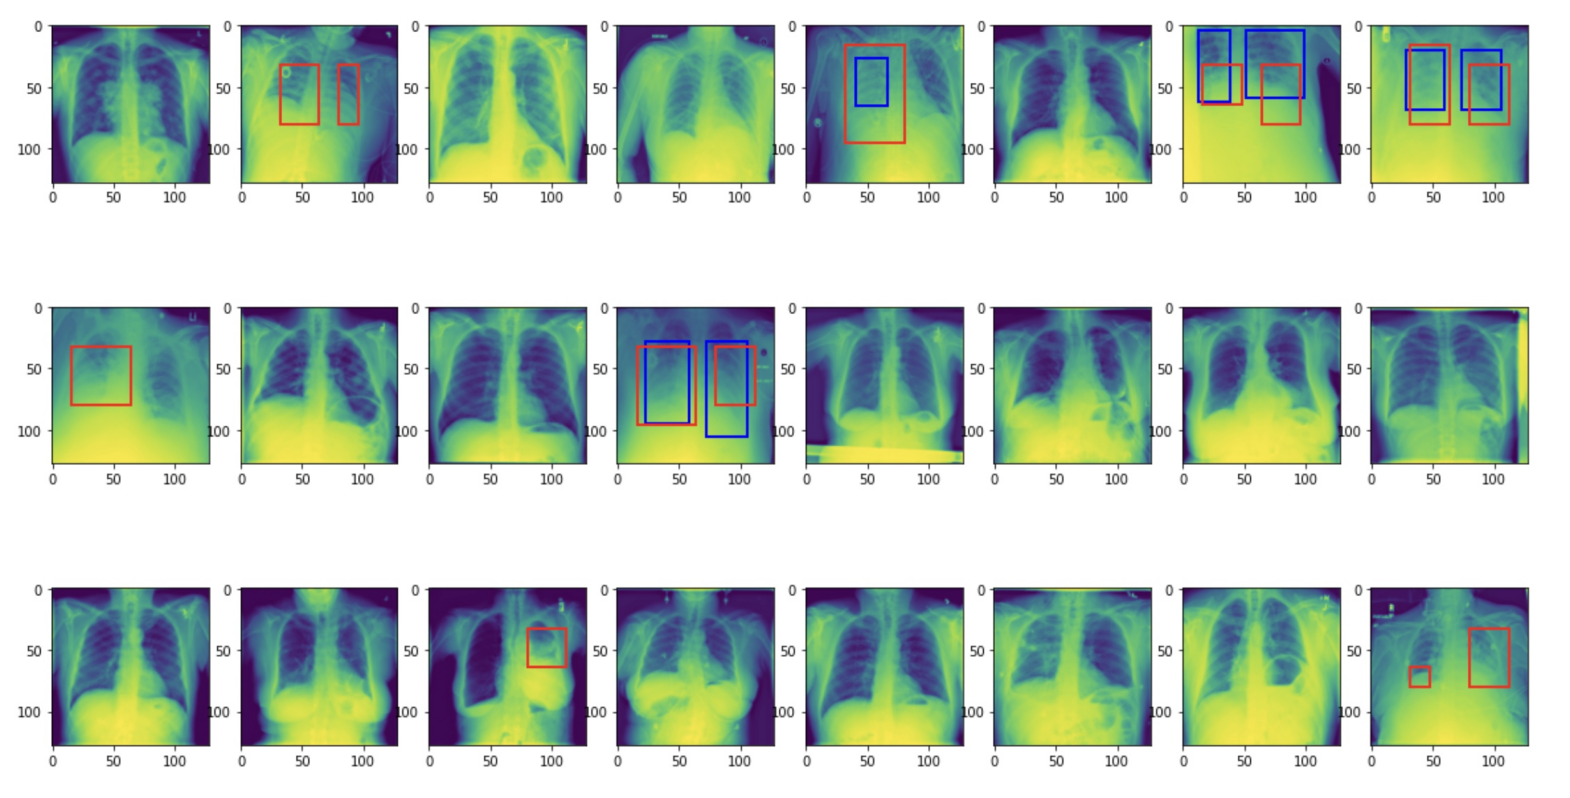

In [62]:
# Red is predicted mask, Blue is actual Mask
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    
    # Flatten the array
    axarr = axarr.ravel()
    axidx = 0
    
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

    # There was considerable IOU for the images where prediction was correct. 

In [61]:
# load and shuffle filenames
folder = PATH+'Data/stage_2_test_images'
test_filenames = os.listdir(folder)[:100]
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=image_dimension, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub

   epoch  accuracy  average_precision  f1_score      loss  val_accuracy  \
0      0  0.810380           0.607783  0.503984  0.423236      0.777361   
1      1  0.835394           0.689382  0.565105  0.373140      0.814093   
2      2  0.841297           0.703855  0.584626  0.360851      0.847826   
3      3  0.842655           0.706988  0.588117  0.352770      0.851949   
4      4  0.845372           0.722601  0.590521  0.345819      0.847826   
5      5  0.850056           0.729392  0.611054  0.339491      0.848201   
6      6  0.849822           0.720376  0.611356  0.334841      0.851199   
7      7  0.851555           0.726668  0.614395  0.329653      0.844828   
8      8  0.855865           0.739966  0.626997  0.324134      0.849700   
9      9  0.858394           0.741915  0.635699  0.317258      0.842954   

   val_average_precision  val_f1_score  val_loss  
0               0.095238      0.032447  0.503525  
1               0.566408      0.607371  0.453682  
2               0.737

## **Conclusion**
We have achieved accuracy of 96-97% with validation loss of 0.4. IOU was higher than 70%.
And in the test data it has an accuracy of about 83%